# PyData 2023

### *Going beyond ChatGPT: an introduction to prompt engineering and LLMs*

**Author:** Ties de Kok ([website](https://www.tiesdekok.com), [github](https://github.com/tiesdekok))    
**Last updated:** April 2023

----
# Setup 
---

## Imports   

All the dependencies required for this notebook are provided in the `environment.yml` file.

To install: `conda env create -f environment.yml` --> this creates the `pydata` environment.

I recommend using Python 3.9 or higher to avoid dependency conflicts.

In [1]:
import os, sys, time, math, re, copy, random, json
import getpass
from pathlib import Path
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

import openai
import tiktoken
import langchain as lc

In [2]:
from sklearn.metrics import classification_report

## Settings

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

## Utility functions

In [4]:
## This function makes it easier to print rendered markdown through a code cell.

from IPython.display import Markdown

def mprint(text, *args, **kwargs):
    if 'end' in kwargs.keys():
        text += kwargs['end']
        
    display(Markdown(text))

### Logic functionality

Running the cell below will log all requests made to the OpenAI API into a log file. 

It also provides two helper functions:

- `print_recent_requests(n = 3)`
- `clear_log_file()`

This might not work on your end, so I've commented them out by default.

In [5]:
#%run -i log_requests.py

#clear_log_file()

## OpenAI key

The GLLMs we will be interacting with are available through the OpenAI API.  

To use the OpenAI API you will need an API key. If you don't have one, follow these steps:   

1. Create an OpenAI account --> https://platform.openai.com   
2. Create an OpenAI API key --> https://platform.openai.com/account/api-keys   
3. You will get \\$5 in free credits if you create a new account. If you've used that up, you will need to add a payment method. The code in this notebook will cost less than a dollar to run.

Once you have your OpenAI Key, you can set it as the `OPENAI_API_KEY` environment variable (recommended) or enter it directly below.

In [85]:
if 'OPENAI_API_KEY' not in os.environ:
    os.environ['OPENAI_API_KEY'] = getpass.getpass(prompt='Enter your API key: ')
openai.api_key = os.environ['OPENAI_API_KEY']
    
## KEEP YOUR KEY SECURE, ANYONE WITH ACCESS TO IT CAN GENERATE COSTS ON YOUR ACCOUNT!

## Load datasets

#### Json 

In [7]:
with open("data.json", "r", encoding = "utf-8") as f:
    data_dict = json.load(f)
    
for k,v in data_dict.items():
    mprint(f"We have **{len(v)}** rows of data in `{k}`.")

We have **20** rows of data in `app_feedback`.

We have **64** rows of data in `talks`.

#### Excel

In [8]:
company_df = pd.read_excel("dataset.xlsx")
mprint(f"We have **{len(company_df.index)}** rows of data in `company_df`.")

We have **66** rows of data in `company_df`.

-----
# Example #1 - automating ChatGPT through the OpenAI API  
---

## Explore the data

The dataset in `app_feedback` consists of app feedback messages submitted by customers.

In [9]:
feedback_list = data_dict["app_feedback"]
feedback_df = pd.DataFrame(feedback_list)
mprint(f"We have **{len(feedback_df.index)}** feedback items.")

We have **20** feedback items.

In [10]:
feedback_df.sample(5)

,i,message,mentions_performance
13,14,The push notifications can be overwhelming; pl...,0
18,19,The app's performance drops significantly when...,1
11,12,The app could benefit from a better recommenda...,0
19,20,"I really like the app, but it would be nice to...",0
15,16,"I'd love the ability to save items for later, ...",0


In [11]:
obs = feedback_df.sample(1).iloc[0]

mprint(f"""
**Feedback** (*i*: `{obs['i']}` - *performance*: `{obs['mentions_performance']}`):
> {obs['message']}
""")


**Feedback** (*i*: `20` - *performance*: `0`):
> I really like the app, but it would be nice to have a tutorial for first-time users to get familiar with the interface.


----
## Develop our prompt

In [12]:
prompt_template = """
Identify whether the customer feedback text below mentions performance issues with our app.
Answer using the following JSON format = {{"i" : i, "mentions_performance" : 1 or 0}}

Feedback text, i = {i}:   
{message}

JSON = 
""".strip()

In [13]:
obs = feedback_df.sample(1).iloc[0].to_dict()
prompt = prompt_template.format(**obs)
print(prompt)

Identify whether the customer feedback text below mentions performance issues with our app.
Answer using the following JSON format = {"i" : i, "mentions_performance" : 1 or 0}

Feedback text, i = 3:   
The app often becomes unresponsive, especially when browsing through the product list. It's very frustrating.

JSON =


### How much tokens would this use?

In [14]:
encoder = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [15]:
len(encoder.encode(prompt))

70

In [16]:
completion_demo = """{"i": 16, "mentions_performance": 0}"""
len(encoder.encode(completion_demo))

13

**How much would this costs?**

Pricing as of April 2023 (https://openai.com/pricing):

- **gpt-3.5-turbo:** \\$0.002 / 1K tokens
- **gpt-4 (8k context):** \\$0.03 / 1K tokens
- **gpt-3 - Davinci:** \\$0.02 / 1K tokens

In [17]:
num_tokens = 100
num_items = 20
price_per_1000_tokens = 0.002

cost = (num_tokens/1000) * price_per_1000_tokens * num_items
mprint(f"""Running all **{num_items:,}** items would cost around **~${cost}**.""")

Running all **20** items would cost around **~$0.004**.

In [18]:
num_tokens = 100
num_items = 100_000
price_per_1000_tokens = 0.002

cost = (num_tokens/1000) * price_per_1000_tokens * num_items
mprint(f"""Running all **{num_items:,}** items would cost around **~${cost}**.""")

Running all **100,000** items would cost around **~$20.0**.

### Generate a list of prompts

In [19]:
for row in feedback_list:
    prompt = prompt_template.format(**row)
    row["prompt"] = prompt

In [20]:
print(feedback_list[10]["prompt"])

Identify whether the customer feedback text below mentions performance issues with our app.
Answer using the following JSON format = {"i" : i, "mentions_performance" : 1 or 0}

Feedback text, i = 11:   
I've been experiencing slow performance when trying to view my order history. It would be great if you could look into this.

JSON =


## Feed prompt to OpenAI API  

OpenAI has many models:  
https://platform.openai.com/docs/models/overview


We are interested in the completion APIs, which come in two types:

- **Text completion:** `GPT-3` (i.e., davinci, curie, babbage, ada)
- **Chat completion:** `GPT-3.5` (ChatGPT) and `GPT-4`

#### Example item

In [21]:
obs = feedback_df.sample(1).iloc[0].to_dict()
prompt = prompt_template.format(**obs)
mprint(f"""Estimate of token usage for the prompt: **{len(encoder.encode(prompt))}** tokens.""")
print(prompt)

Estimate of token usage for the prompt: **70** tokens.

Identify whether the customer feedback text below mentions performance issues with our app.
Answer using the following JSON format = {"i" : i, "mentions_performance" : 1 or 0}

Feedback text, i = 9:   
It's annoying when the app takes so long to process a payment. Can you improve the speed?

JSON =


### Chat completion endpoint

In [22]:
res = openai.ChatCompletion.create(
    model="gpt-3.5-turbo", ## or gpt-4
    temperature = 0,
    max_tokens = 300,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
)

res = res.to_dict_recursive()
res

{'id': 'chatcmpl-79Hh80NTvZVP1f6EGhvPZlGrMllkd',
 'object': 'chat.completion',
 'created': 1682447326,
 'model': 'gpt-3.5-turbo-0301',
 'usage': {'prompt_tokens': 89, 'completion_tokens': 15, 'total_tokens': 104},
 'choices': [{'message': {'role': 'assistant',
    'content': '{"i" : 9, "mentions_performance" : 1}'},
   'finish_reason': 'stop',
   'index': 0}]}

**We can easily process this back into Python:**

In [23]:
content = res["choices"][0]["message"]["content"]
content

'{"i" : 9, "mentions_performance" : 1}'

In [24]:
pred_dict = json.loads(content)
pred_dict

{'i': 9, 'mentions_performance': 1}

### Text completion endpoint

The `gpt-3.5-turbo` API is generally the best value for money, however, you can't fine-tune it (yet?).   

Fine-tuning is available for the GPT-3 series, which consists of the following models (from most powerful to least expensive):

- `davinci`   
- `curie`   
- `babbage`   
- `ada`   

Generally speaking you won't get good results with `curie` / `babbage` / `ada` unless you fine-tune them.

In [25]:
model = "text-davinci-003"
#model = "text-curie-001"
#model = "text-babbage-001"
#model = "text-ada-001"

res = openai.Completion.create(
    model = model,
    temperature = 0,
    max_tokens = 300,
    prompt = prompt
)

res = res.to_dict_recursive()
res

{'id': 'cmpl-79HhAoxthFU2OU63wyd3F7erjQRth',
 'object': 'text_completion',
 'created': 1682447328,
 'model': 'text-davinci-003',
 'choices': [{'text': ' {"i" : 9, "mentions_performance" : 1}',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 76, 'completion_tokens': 15, 'total_tokens': 91}}

---
## Generate predictions for all feedback items

#### Wrap things up in a function

In [26]:
def process_item(obs, model = "gpt-3.5-turbo", 
                prompt_template = prompt_template, 
                verbose = 0):
    ## Create prompt
    prompt = prompt_template.format(**obs)
    if verbose > 0: print(prompt)
    
    ## Generate prediction
    res = openai.ChatCompletion.create(
        model = model,
        temperature = 0,
        max_tokens = 300,
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    
    ## Process prediction
    res = res.to_dict_recursive()
    content = res["choices"][0]["message"]["content"]
    pred_dict = json.loads(content)
    pred_dict["original_i"] = obs["i"]
    
    return pred_dict

#### Test

In [27]:
obs = feedback_df.sample(1).iloc[0].to_dict()
res = process_item(obs, verbose = 1)
res

Identify whether the customer feedback text below mentions performance issues with our app.
Answer using the following JSON format = {"i" : i, "mentions_performance" : 1 or 0}

Feedback text, i = 15:   
Sometimes the app hangs when I try to update my profile info. Is there a way to fix this?

JSON =


{'i': 15, 'mentions_performance': 1, 'original_i': 15}

#### Run for all observations

In [28]:
prediction_list = []
for row in tqdm(feedback_list):
    res = process_item(row)
    prediction_list.append(res)

  0%|          | 0/20 [00:00<?, ?it/s]

In [29]:
prediction_df = pd.DataFrame(prediction_list)

In [30]:
## Double check to make sure ChatGPT followed our instructions:
assert all(prediction_df["i"] == prediction_df["original_i"]), "The generated index is not the same..."

#### Evaluate

In [31]:
prediction_df = prediction_df.drop("i", axis = 1, errors = "ignore").rename(columns = {
    "mentions_performance" : "prediction",
    "original_i" : "i"
})

In [32]:
feedback_df = pd.merge(feedback_df, prediction_df, on = "i", how = "left")

In [33]:
feedback_df.head(3)

,i,message,mentions_performance,prediction
0,1,"The app is great, but it takes a while to load...",1,1
1,2,"I love the design and functionality, but I wis...",0,0
2,3,"The app often becomes unresponsive, especially...",1,1


In [34]:
print(classification_report(
    feedback_df["mentions_performance"], 
    feedback_df["prediction"]
))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



---
## Side-note: how to speed things up?

The ChatGPT model is slow, and the GPT-4 model is extremely slow.

For example, this task took ~23 seconds for 20 observations, that is about a second per prediction!

100,000 predictions * 1 second = ~28 hours...

**How do we speed things up?**

There are several ways to speed things up:

**1. Don't run predictions on data you don't need predictions for.**

**2. The GPT-3 endpoints support batching up to 20 predictions at a time.**

**3. Combine multiple predictions into a single prompt**

In [35]:
%%time
prompt = """
Identify whether the customer feedback texts below mentions performance issues with our app.
Answer using the following JSON format = [{{"i" : i, "mentions_performance" : 1 or 0}}, ...]

to_classify = [
{"i" : 1, "message" : "The app is great, but it takes a while to load the main screen. Can you improve the performance?"}
{"i" : 2, "message" : "I love the design and functionality, but I wish there was a dark mode."}
{"i" : 3, "message" : "The app often becomes unresponsive, especially when browsing through the product list. It's very frustrating."}
{"i" : 4, "message" : "I appreciate the recent update, but please add more filter options when searching for items."}
{"i" : 5, "message" : "The app is slow to load images, which makes it hard to browse products efficiently. Otherwise, it's a great app!"}
]

JSON = 
"""

res = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    temperature = 0,
    max_tokens = 500,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
)

res = res.to_dict_recursive()
content = res["choices"][0]["message"]["content"]
pred_dict = json.loads(content)
pred_dict

CPU times: total: 15.6 ms
Wall time: 7.47 s


[{'i': 1, 'mentions_performance': 1},
 {'i': 2, 'mentions_performance': 0},
 {'i': 3, 'mentions_performance': 1},
 {'i': 4, 'mentions_performance': 0},
 {'i': 5, 'mentions_performance': 1}]

**4. Saturate the rate limits by making async requests**

Limits for the ChatGPT API:
- 3,500 RPM (Requests-per-minute)
- 90,000 TPM (Tokens-per-minute)

**Theoretical throughput:** 90,000 / 120 tokens = 750 predictions per minute    
**Sequential throughput:** 60 predictions per minute

So we can potentially speed things up 12x with an async approach!

For an implementation example, see the OpenAI Cookbook:

- https://github.com/openai/openai-cookbook/blob/main/examples/How_to_handle_rate_limits.ipynb
- https://github.com/openai/openai-cookbook/blob/297c53430cad2d05ba763ab9dca64309cb5091e9/examples/api_request_parallel_processor.py

-----
# Example #2 - LangChain - Simple replication
---

Source documents:
- https://github.com/hwchase17/langchain/blob/master/docs/getting_started/getting_started.md

### Imports

In [36]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)

### Replication

#### Define chat object

In [37]:
chat = ChatOpenAI(model_name="gpt-3.5-turbo", temperature = 0)

#### Define prompt template

In [38]:
human_message_prompt = HumanMessagePromptTemplate.from_template(prompt_template)
chat_prompt = ChatPromptTemplate.from_messages([human_message_prompt])

#### Generate prediction

In [39]:
obs = feedback_df.sample(1).iloc[0].to_dict()
prompt = chat_prompt.format_prompt(**obs)
print(prompt)

messages=[HumanMessage(content='Identify whether the customer feedback text below mentions performance issues with our app.\nAnswer using the following JSON format = {"i" : i, "mentions_performance" : 1 or 0}\n\nFeedback text, i = 10:   \nPlease add a feature to create and share wish lists with friends and family.\n\nJSON =', additional_kwargs={})]


In [40]:
res = chat(prompt.to_messages())
res

AIMessage(content='{"i" : 10, "mentions_performance" : 0}', additional_kwargs={})

In [41]:
json.loads(res.content)

{'i': 10, 'mentions_performance': 0}

In [42]:
#print_recent_requests()


----------------------------------------------------------------------------------------------------
Order: 0
----------------------------------------------------------------------------------------------------

---Chat prompt:--- [{"role": "user", "content": "Identify whether the customer feedback text below mentions performance issues with our app.
Answer using the following JSON format = {"i" : i, "mentions_performance" : 1 or 0}

Feedback text, i = 10:   
Please add a feature to create and share wish lists with friends and family.

JSON ="}]


-----
# Example #3 - LangChain - PyData session recommender
---

Source documents:
- https://python.langchain.com/en/latest/modules/chains/index_examples/question_answering.html

### Imports

In [43]:
from langchain.llms.openai import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains.question_answering import load_qa_chain
from langchain import PromptTemplate
from langchain.document_loaders import DataFrameLoader

### Data

In [44]:
talk_list = data_dict["talks"]
talk_df = pd.DataFrame(talk_list)
talk_df.sample(5)

,title,abstract,start_datetime,speakers
42,"Python Anytime, Anywhere with Anaconda Notebooks",Do you wish there was an easier way to get sta...,Friday 2023-28-04 - 10:15 AM,Sophia Yang
0,Automated Machine Learning & Tuning with FLAML,"In this session, we will provide an in-depth a...",Wednesday 2023-26-04 - 09:00 AM,"Li Jiang, Chi Wang, Qingyun Wu, Misha Desai"
38,MLOps Deployment Patterns with Delta Lake and ...,Would you be better off deploying an ML model ...,Thursday 2023-27-04 - 04:15 PM,Mary Grace Moesta
16,Keynote: Scientific Computing and the Gateway ...,"Over the last decade, we have seen innumerable...",Thursday 2023-27-04 - 09:00 AM,Katrina Riehl
7,"Building Reliable, Open Lakehouses with Delta ...",Delta Lake: Building Reliable and Scalable Ope...,Wednesday 2023-26-04 - 11:00 AM,Jim Hibbard


### Preparation steps

##### Initialize the OpenAI models

In [45]:
chatModel = ChatOpenAI(
    model_name = 'gpt-3.5-turbo',
    temperature=0, 
    max_tokens = 2048
)

##### Let's prepare our input documents

In [46]:
talk_df["full_text"] = talk_df.apply(lambda row: f"""
Title: {row["title"]}
Speakers: {row["speakers"]}
Start: {row["start_datetime"]}
Abstract:
{row["abstract"]}""".strip()
, axis = 1)

In [47]:
print(talk_df.iloc[0]["full_text"])

Title: Automated Machine Learning & Tuning with FLAML
Speakers: Li Jiang, Chi Wang, Qingyun Wu, Misha Desai
Start: Wednesday 2023-26-04 - 09:00 AM
Abstract:
In this session, we will provide an in-depth and hands-on tutorial on Automated Machine Learning & Tuning with a fast python library named FLAML. We will start with an overview of the AutoML problem and the FLAML library. We will then introduce the hyperparameter optimization methods empowering the strong performance of FLAML. We will also demonstrate how to make the best use of FLAML to perform automated machine learning and hyperparameter tuning in various applications with the help of rich customization choices and advanced functionalities provided by FLAML. At last, we will share several new features of the library based on our latest research and development work around FLAML and close the tutorial with open problems and challenges learned from AutoML practice.


## Figure out a way to find relevant events

https://python.langchain.com/en/latest/modules/chains/index_examples/question_answering.html

##### Design our prompt to convert the relevant sessions into a brief conference plan:

In [48]:
prompt_template = """You are an assistant that helps the user plan their PyData visit. Below are the tasks relevant to the users request. Here are your task requirements:
- Convert the list into a conference plan split out by day.
- Include a brief one-sentence summary for each recommendation. 
- Always also include the title, date, and speakers. 
- Avoid overlapping sessions. If there is overlap, pick the session most relevant.
- If a session accidentally does not relate to what the user is looking for, exclude it. 
- Make sure the sessions are sorted chronologically. 
- Format the planning using markdown. Make sure it is easy to read, has nice spacing, and looks professionally.
- Only include session mentioned under "Relevant talks". Never make up sessions.

Relevant talks:
{summaries}

What the user is looking for: {question}

Conference plan:"""
schedule_prompt = PromptTemplate(
    template=prompt_template, input_variables=["summaries", "question"]
)

##### The issue:
We can't fit all the events into a single prompt:

In [49]:
all_events = ", ".join(talk_df["full_text"].to_list())
mprint(f"""Total number of tokens for all the talks: **{len(encoder.encode(all_events)):,}** tokens""")

Total number of tokens for all the talks: **10,513** tokens

**How do we solve/bypass this problem?**
 
`LangChain` provides several solutions to deal with this (`map_reduce`, `refine`, and `map_rerank`).

I won't go into the details here, but essentially these methods will chunk up the problem and then feed the chunks back into aggregation prompts.

This is easier to demonstrate than to explain:

In [50]:
summarize_prompt_template = """
Check if the following session is relevant for what the user is looking for. 
If it is relevant, summarize the abstract and return using the following JSON format = {{"author" .. , "date" : .., "title" : .. "abstract_summary" ..}}.
If not relevant, return "".
{context}
User request: {question}
JSON = 
""".strip()
summarize_prompt = PromptTemplate(
    template=summarize_prompt_template, input_variables=["context", "question"]
)

##### Create function to run it all

In [51]:
def get_conference_plan(query, docs, verbose = False, model = chatModel, combine_prompt = schedule_prompt, question_prompt = summarize_prompt):
    chain = load_qa_chain(
        model, 
        chain_type="map_reduce", ## stuff, map_reduce, refine, map_rerank
        combine_prompt = combine_prompt, 
        question_prompt = question_prompt,
        verbose = verbose
    )

    result = chain({
        "input_documents" : docs.load(), 
        "question": query
    }, return_only_outputs=True)
    
    return result["output_text"]

##### Create a conference plan based on a user query:

In [52]:
docs = DataFrameLoader(talk_df.iloc[15:20], page_content_column="full_text") ## This is really slow for all docs

In [53]:
#clear_log_file()

In [54]:
query = "I love sessions that relate to scientific computing"
plan = get_conference_plan(query, docs, verbose = True)



> Entering new MapReduceDocumentsChain chain...
Prompt after formatting:
Check if the following session is relevant for what the user is looking for. 
If it is relevant, summarize the abstract and return using the following JSON format = {"author" .. , "date" : .., "title" : .. "abstract_summary" ..}.
If not relevant, return "".
Title: Panel: “Building a Stronger Open Source Python Data Community: Trends, Gaps, and Collaborative Contributions”
Speakers: Hamel Husain, Stefan Krawczyk, Katrina Riehl, Juanita Gomez, Zander Matheson
Start: Wednesday 2023-26-04 - 03:30 PM
Abstract:
Expert on the field of software will share their stories in their journey of building a strong open source Python data community.
User request: I love sessions that relate to scientific computing
JSON =
Prompt after formatting:
Check if the following session is relevant for what the user is looking for. 
If it is relevant, summarize the abstract and return using the following JSON format = {"author" .. , "date"

In [55]:
print(plan)

## PyData Conference Plan

### Thursday, April 27th

- **9:00 AM - 10:00 AM** Keynote: Scientific Computing and the Gateway to Open Source  
  *Speaker: Katrina Riehl*  
  This talk reviews how the NumFOCUS organization contributes to the support, sustainability, and diversity of a vibrant scientific open source community.

- **10:15 AM - 11:15 AM** A Perfect, Infinite-Precision, Game Physics in Python  
  *Speaker: Carl Kadie*  
  This fun and visual talk shows how to create a perfect (but impractical) physics engine in Python using SymPy, a free package for computer algebra. This session is relevant for those interested in scientific computing and the limits of simulation and programming.

- **10:15 AM - 11:15 AM** Quantifying Uncertainty in Time Series Forecasting with Conformal Prediction  
  *Speakers: Federico Garza Ramirez, Max Mergenthaler*  
  This talk will examine the use of conformal prediction in the context of time series analysis. The presentation will highlight the bene

In [56]:
mprint(plan)

## PyData Conference Plan

### Thursday, April 27th

- **9:00 AM - 10:00 AM** Keynote: Scientific Computing and the Gateway to Open Source  
  *Speaker: Katrina Riehl*  
  This talk reviews how the NumFOCUS organization contributes to the support, sustainability, and diversity of a vibrant scientific open source community.

- **10:15 AM - 11:15 AM** A Perfect, Infinite-Precision, Game Physics in Python  
  *Speaker: Carl Kadie*  
  This fun and visual talk shows how to create a perfect (but impractical) physics engine in Python using SymPy, a free package for computer algebra. This session is relevant for those interested in scientific computing and the limits of simulation and programming.

- **10:15 AM - 11:15 AM** Quantifying Uncertainty in Time Series Forecasting with Conformal Prediction  
  *Speakers: Federico Garza Ramirez, Max Mergenthaler*  
  This talk will examine the use of conformal prediction in the context of time series analysis. The presentation will highlight the benefits of using conformal prediction to estimate uncertainty and demonstrate its application using open source python libraries for statistical, machine learning, and deep learning models.

- **10:15 AM - 11:15 AM** Plant a Touch-Me-Not: Train Models Without Anyone Touching Your Data with Flower  
  *Speaker: Krishi Sharma*  
  This session discusses the challenges of leveraging multiple datasets in machine learning without breaching data privacy and security, particularly in medical and legal services. The speaker explores ways to train models without centralizing data in one place, using Flower technology.

In [57]:
#print_recent_requests(20)


----------------------------------------------------------------------------------------------------
Order: 0
----------------------------------------------------------------------------------------------------

---Chat prompt:--- [{"role": "user", "content": "You are an assistant that helps the user plan their PyData visit. Below are the tasks relevant to the users request. Here are your task requirements:
- Convert the list into a conference plan split out by day.
- Include a brief one-sentence summary for each recommendation. 
- Always also include the title, date, and speakers. 
- Avoid overlapping sessions. If there is overlap, pick the session most relevant.
- If a session accidentally does not relate to what the user is looking for, exclude it. 
- Make sure the sessions are sorted chronologically. 
- Format the planning using markdown. Make sure it is easy to read, has nice spacing, and looks professionally.
- Only include session mentioned under "Relevant talks". Never make up

-----
# Example #4 - LangChain - PyData session recommender with a vector lookup
---

Source documents:
- https://python.langchain.com/en/latest/modules/chains/index_examples/question_answering.html

### Imports

In [58]:
from langchain.llms.openai import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains.question_answering import load_qa_chain

### Data

In [59]:
talk_df.sample(5)

,title,abstract,start_datetime,speakers,full_text
28,Scaling Altair visualizations with VegaFusion,Altair is a popular Python visualization libra...,Thursday 2023-27-04 - 11:45 AM,Jon Mease,Title: Scaling Altair visualizations with Vega...
51,Scaling MLOps to support dozens of analytics t...,"In this talk, we will present best practices a...",Friday 2023-28-04 - 11:45 AM,Ilya Katsov,Title: Scaling MLOps to support dozens of anal...
24,Shiny: Data-centric web applications in Python,Shiny is a web framework that is designed to l...,Thursday 2023-27-04 - 11:00 AM,Joe Cheng,Title: Shiny: Data-centric web applications in...
25,Experimentation and the gold standard of data ...,We will discuss industry best practices for le...,Thursday 2023-27-04 - 11:45 AM,"Timothy Chan, PhD",Title: Experimentation and the gold standard o...
34,Computer Vision Landscape at Chegg: Present an...,Millions of people all around the world Learn ...,Thursday 2023-27-04 - 03:30 PM,Sanghamitra Deb,Title: Computer Vision Landscape at Chegg: Pre...


### Preparation steps

##### Initialize the OpenAI models

In order to look up related talks we can use a vector similarity search:

In [60]:
embeddings = OpenAIEmbeddings(
    model = 'text-embedding-ada-002'
)

To create the final plan, we will use the ChatGPT api or the GPT-3 Davinci api:

In [61]:
chatModel = ChatOpenAI(
    model_name = 'gpt-3.5-turbo',
    temperature=0, 
    max_tokens = 1024
)

##### Let's prepare our input documents

In [62]:
texts, metadatas = [], []
for i, row in talk_df.iterrows():
    texts.append(row["full_text"])
    metadatas.append({"source" : i})

## Find relevant events

Instead of making calls to the LLM to identify relevant talks, we can instead simply do a vector similarity search and identify relevant talks that way.

This is much quicker, cheaper, and more scaleable. 

##### Get the embeddings and store them in our Chroma vector database

Want to learn more about ChromaDB? --> https://www.trychroma.com/

In [63]:
docsearch = Chroma.from_texts(texts, embeddings, metadatas=metadatas).as_retriever()

##### Design our prompt to convert the relevant sessions into a brief conference plan:

In [64]:
prompt_template = """You are an assistant that helps the user plan their PyData visit. Below are the tasks relevant to the users request. Here are your task requirements:
- Convert the list into a conference plan split out by day.
- Include a brief 2-sentence summary for each recommendation. 
- Always also include the title, date, and speakers. 
- Avoid overlapping sessions. If there is overlap, pick the session most relevant.
- If a session accidentally does not relate to what the user is looking for, exclude it. 
- Make sure the sessions are sorted chronologically. 
- Format the planning using markdown. Make sure it is easy to read, has nice spacing, and looks professionally.

Relevant talks:
{context}

What the user is looking for: {question}

Conference plan:"""
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

##### Create function to run it all

In [65]:
def get_conference_plan(query, docsearch = docsearch, verbose = False, model = chatModel):
    chain = load_qa_chain(model, chain_type="stuff", prompt=PROMPT, verbose = verbose)

    docs = docsearch.get_relevant_documents(query)
    result = chain({
        "input_documents" : docs, 
        "question": query
    }, return_only_outputs=True)
    
    return result["output_text"]

##### Create a conference plan based on a user query:

In [66]:
#clear_log_file()

In [67]:
query = "I love sessions that relate to Pandas or geospatial data."
plan = get_conference_plan(query, verbose = False)

In [68]:
print(plan)

## PyData Conference Plan

### Wednesday 2023-26-04
- **Title: Introduction to Working with U.S. Census Data in Python**
  - Speaker: Darren Vengroff
  - Start: 01:30 PM
  - Summary: This tutorial will demonstrate how open-source Python tools can be used to discover, download, analyze, and generate maps of U.S. Census data. Attendees will learn to download demographic and economic indicators at levels ranging from the entire nation to individual neighborhoods and plot the data on maps.

### Thursday 2023-27-04
- **Title: Data Mapping for Data Exploration**
  - Speaker: Leland McInnes
  - Start: 11:45 AM
  - Summary: This session will explore interactive data maps as a tool for exploratory data analysis, using 2D map style representations of the data, combined with rich interactivity that can link back to the source data.

### Friday 2023-28-04
- **Title: Scaling data workloads using the best of both worlds: pandas and Spark**
  - Speakers: Chengyin Eng, Hyukjin Kwon
  - Start: 10:15 AM

In [69]:
mprint(plan)

## PyData Conference Plan

### Wednesday 2023-26-04
- **Title: Introduction to Working with U.S. Census Data in Python**
  - Speaker: Darren Vengroff
  - Start: 01:30 PM
  - Summary: This tutorial will demonstrate how open-source Python tools can be used to discover, download, analyze, and generate maps of U.S. Census data. Attendees will learn to download demographic and economic indicators at levels ranging from the entire nation to individual neighborhoods and plot the data on maps.

### Thursday 2023-27-04
- **Title: Data Mapping for Data Exploration**
  - Speaker: Leland McInnes
  - Start: 11:45 AM
  - Summary: This session will explore interactive data maps as a tool for exploratory data analysis, using 2D map style representations of the data, combined with rich interactivity that can link back to the source data.

### Friday 2023-28-04
- **Title: Scaling data workloads using the best of both worlds: pandas and Spark**
  - Speakers: Chengyin Eng, Hyukjin Kwon
  - Start: 10:15 AM
  - Summary: This talk will equip data analysts and scientists with the knowledge of scaling their data analysis workloads with implementation details and best practice guidance, using pandas API on Spark to transition from single-node to distributed environment. Working knowledge of pandas, basic Spark, and machine learning is helpful.

- **Title: Fugue: Porting Existing Python and Pandas Code to Spark, Dask, and Ray**
  - Speakers: Kevin Kho, Anthony Holten
  - Start: 02:00 PM
  - Summary: This tutorial will show how to port existing Pandas code to distributed backend with minimal rewrites, using Fugue. It will cover some scenarios where the Pandas interface can't scale.

In [70]:
#print_recent_requests(5)


----------------------------------------------------------------------------------------------------
Order: 0
----------------------------------------------------------------------------------------------------

---Chat prompt:--- [{"role": "user", "content": "You are an assistant that helps the user plan their PyData visit. Below are the tasks relevant to the users request. Here are your task requirements:
- Convert the list into a conference plan split out by day.
- Include a brief 2-sentence summary for each recommendation. 
- Always also include the title, date, and speakers. 
- Avoid overlapping sessions. If there is overlap, pick the session most relevant.
- If a session accidentally does not relate to what the user is looking for, exclude it. 
- Make sure the sessions are sorted chronologically. 
- Format the planning using markdown. Make sure it is easy to read, has nice spacing, and looks professionally.

Relevant talks:
Title: Data Mapping for Data Exploration
Speakers: Lela

-----
# Example #5 - LangChain - DataFrame analyzer using an "agent"
-----

<span style="display: inline-block; background-color: #E53935; color: white; font-size: 1.2rem; font-weight: bold; padding: 8px 16px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.25); text-align:center;">This function will allow the GLLM to execute code directly into the Python kernel. <br>Use with caution!</span>

Source documents:
- https://python.langchain.com/en/latest/modules/agents/toolkits/examples/pandas.html

### Imports

In [71]:
from langchain.agents import create_pandas_dataframe_agent
from langchain.chat_models import ChatOpenAI

### Data

In [72]:
company_df.head(4).T

,0,1,2,3
Global Company Key,1690,1690,1690,1690
Data Date,2010-09-30 00:00:00,2011-09-30 00:00:00,2012-09-30 00:00:00,2013-09-30 00:00:00
Data Year - Fiscal,2010,2011,2012,2013
Industry Format,INDL,INDL,INDL,INDL
Level of Consolidation - Company Annual Descriptor,C,C,C,C
Population Source,D,D,D,D
Data Format,STD,STD,STD,STD
Ticker Symbol,AAPL,AAPL,AAPL,AAPL
Company Name,APPLE INC,APPLE INC,APPLE INC,APPLE INC
ISO Currency Code,USD,USD,USD,USD


### Set up agent

In [73]:
chatModel = ChatOpenAI(
    model_name = 'gpt-3.5-turbo', # 'gpt-4'
    temperature=0, 
    max_tokens = 2040
)

In [74]:
agent = create_pandas_dataframe_agent(
    chatModel, 
    company_df, 
    verbose=True,
    max_iterations = 10
)

### Run a simple example

In [75]:
#clear_log_file()

In [76]:
agent.run("How many rows are there?")



> Entering new AgentExecutor chain...
Thought: I can use the `shape` attribute of the dataframe to get the number of rows and columns.
Action: python_repl_ast
Action Input: df.shape[0]
Observation: 66
Thought:I now know the final answer
Final Answer: There are 66 rows in the dataframe.

> Finished chain.


'There are 66 rows in the dataframe.'

**What did the prompts look like?**

In [77]:
#print_recent_requests(3)


----------------------------------------------------------------------------------------------------
Order: 0
----------------------------------------------------------------------------------------------------

---Chat prompt:--- [{"role": "user", "content": "
You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
You should use the tools below to answer the question posed of you:

python_repl_ast: A Python shell. Use this to execute python commands. Input should be a valid python command. When using this tool, sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [python_repl_ast]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I no

### More advanced example

In [78]:
#clear_log_file()

In [79]:
agent.run("Which company has the most cash on hand accross all the years?")



> Entering new AgentExecutor chain...
Thought: We need to group the data by company name and then sum the cash column for each company. Then we can find the company with the highest cash value.
Action: python_repl_ast
Action Input:
df.groupby('Company Name')['Cash'].sum().sort_values(ascending=False).head(1)
Observation: Company Name
APPLE INC    293177.0
Name: Cash, dtype: float64
Thought:The company with the most cash on hand across all the years is APPLE INC with a total of 293177.0. 
Final Answer: APPLE INC

> Finished chain.


'APPLE INC'

**What did the prompts look like?**

In [80]:
#print_recent_requests(10)


----------------------------------------------------------------------------------------------------
Order: 0
----------------------------------------------------------------------------------------------------

---Chat prompt:--- [{"role": "user", "content": "
You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
You should use the tools below to answer the question posed of you:

python_repl_ast: A Python shell. Use this to execute python commands. Input should be a valid python command. When using this tool, sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [python_repl_ast]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I no

### Interesting edge case:

In [81]:
agent = create_pandas_dataframe_agent(
    chatModel, 
    company_df, 
    verbose=True,
    max_iterations = 2
)

In [82]:
#clear_log_file()



> Entering new AgentExecutor chain...
Thought: We need to group the data by company and then plot the cash column over time.
Action: python_repl_ast
Action Input:
```
import matplotlib.pyplot as plt
grouped = df.groupby('Company Name')
for name, group in grouped:
    plt.plot(group['Data Date'], group['Cash'], label=name)
plt.legend()
plt.show()
```

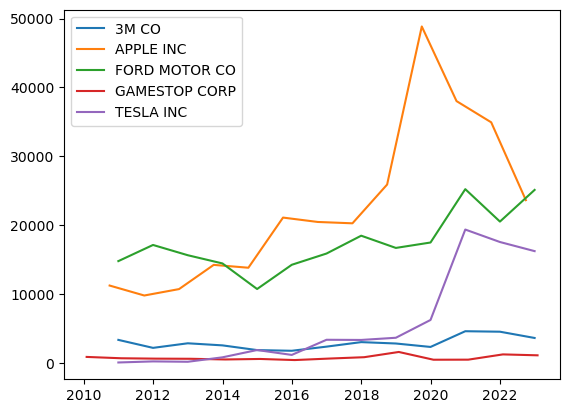


Observation: None
Thought:The code should have created a graph, but it didn't. Let's try to debug it.
Action: python_repl_ast
Action Input:
```
import matplotlib.pyplot as plt
grouped = df.groupby('Company Name')
for name, group in grouped:
    print(name)
    print(group['Data Date'])
    print(group['Cash'])
    plt.plot(group['Data Date'], group['Cash'], label=name)
plt.legend()
plt.show()
```3M CO
26   2010-12-31
27   2011-12-31
28   2012-12-31
29   2013-12-31
30   2014-12-31
31   2015-12-31
32   2016-12-31
33   2017-12-31
34   2018-12-31
35   2019-12-31
36   2020-12-31
37   2021-12-31
38   2022-12-31
Name: Data Date, dtype: datetime64[ns]
26    3377.0
27    2219.0
28    2883.0
29    2581.0
30    1897.0
31    1798.0
32    2398.0
33    3053.0
34    2853.0
35    2353.0
36    4634.0
37    4564.0
38    3655.0
Name: Cash, dtype: float64
APPLE INC
0    2010-09-30
1    2011-09-30
2    2012-09-30
3    2013-09-30
4    2014-09-30
5    2015-09-30
6    2016-09-30
7    2017-09-30
8    2018-09-

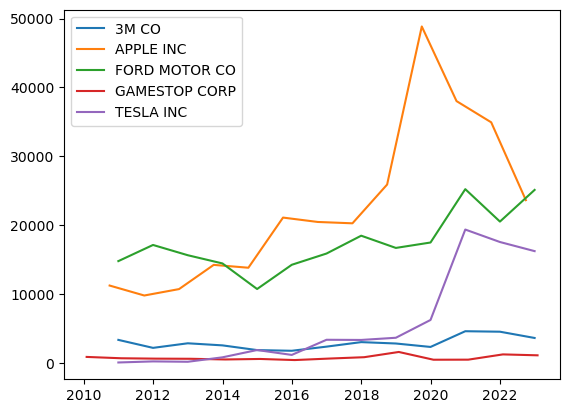


Observation: None
Thought:

> Finished chain.


'Agent stopped due to iteration limit or time limit.'

In [83]:
agent.run("I want to create a graph that shows the cash trends per company over time.", )

In [84]:
#print_recent_requests(n = 3)


----------------------------------------------------------------------------------------------------
Order: 0
----------------------------------------------------------------------------------------------------

---Chat prompt:--- [{"role": "user", "content": "
You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
You should use the tools below to answer the question posed of you:

python_repl_ast: A Python shell. Use this to execute python commands. Input should be a valid python command. When using this tool, sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [python_repl_ast]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I no